## Import Libraries

In [35]:
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from matplotlib import pyplot as plt
import re
import os,sys, shutil
import time
from datetime import date
try:
    import cPickle as pickle
except:
    import pickle
import pprint
from collections import deque
from shutil import copyfile
import random
import glob
# Import the required modules
import cv2, os
import numpy as np
from PIL import Image
from sklearn.cross_validation import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
from collections import Counter
from operator import itemgetter

In [2]:
pkl_fl = open("linkedin_profiles.pickle","rb")
my_original_list=pickle.load(pkl_fl) # errors out here
pkl_fl.close()

## label the Images and store into respective folders

In [3]:
directory = "Male"
    
if os.path.exists(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)     
else:
    os.makedirs(directory) 

directory1 = "Female"

if os.path.exists(directory1):
    shutil.rmtree(directory1)
    os.makedirs(directory1)     
else:
    os.makedirs(directory1)     

directory2 = "Label_Images_Gender"

if os.path.exists(directory2):
    shutil.rmtree(directory2)
    os.makedirs(directory2)     
else:
    os.makedirs(directory2)     
    
fileList = glob.glob("./Images/*.*")

for id,fp in enumerate(fileList):
    filename, file_extension = os.path.splitext(fp)
    uid = filename.split('/')[-1]
    #print fp
    for prof in my_original_list:
        if prof['User_ID'] == uid:
            new_file_extension = prof['Gender']
            new_file_extension = new_file_extension.title()
            #os.rename(fp, filename+"."+new_file_extension)
            copyfile(filename+".jpg", './Label_Images_Gender/'+ uid + '.' + str(id) + "."+new_file_extension +'.jpg')
            copyfile(filename+".jpg", new_file_extension +'/' + uid + ".jpg")

In [3]:
# For face detection we will use the Haar Cascade provided by OpenCV.
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

# For face recognition we will the the LBPH Face Recognizer 
recognizer = cv2.createLBPHFaceRecognizer()

In [10]:
def get_images_and_labels(path):
    # Append all the absolute image paths in a list image_paths
    
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    # images will contains face images
    images = []
    # labels will contains the label that is assigned to the image
    labels = []
    #gender will contains 1 or 0 indecating male or female
    gender =[]
    
    for image_path in image_paths:
        # Read the image and convert to grayscale
        try:
            image_pil = Image.open(image_path).convert('L')
            # Convert the image format into numpy array
            image = np.array(image_pil, 'uint8')
            # Get the label of the image
        except:
            pass
        
        nbr = int(os.path.split(image_path)[1].split(".")[1])
        gender_current = os.path.split(image_path)[1].split(".")[2]
        #print nbr
        
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        try:
            for (x, y, w, h) in faces:

                ref_image = image[y: y + h, x: x + w]
                resized = cv2.resize(ref_image, (100, 100), interpolation = cv2.INTER_AREA)
                edge_images = cv2.Canny(resized,100,200)
                
                images.append(np.hstack((resized.reshape(1,10000), edge_images.reshape(1,10000))))
                labels.append(nbr)

                if gender_current == 'Male':
                    gender.append(1)
                else:
                    gender.append(0)

                cv2.imshow("Adding faces to traning set...", resized)
                cv2.waitKey(1)
        except:
            pass
    # return the images list and labels list
    #print "lables"
    #print labels
    #print "gender_current"
    #print gender
    
    return images, labels, gender

In [11]:
images, labels, gender = get_images_and_labels('Label_Images_Gender')

cv2.destroyAllWindows()

In [25]:
with open("tmp_gender_logistic.pickle", "wb") as f:
    pickle.dump((images,labels,gender), f)

In [15]:
with open("tmp_gender_logistic.pickle", "rb") as f:
    images, labels, gender = pickle.load(f) 

In [16]:
# img = cv2.imread('ankitanarula.jpg',0)
# resized = cv2.resize(img, (100, 100), interpolation = cv2.INTER_AREA)
# edge_images = cv2.Canny(resized,100,200)
# #edges = cv2.Canny(img,100,200)
# plt.subplot(121),plt.imshow(resized,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(edge_images,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
# plt.show()
# edge_images

In [16]:
images[0].shape

(1, 20000)

## Making the Dataset 

In [17]:
res_images = []
res_gender = []

for gen in gender:
    res_gender.append(np.array(gen).reshape(1,))
    
res_images = np.concatenate(images, axis=0)
res_gender = np.concatenate(res_gender,axis=0)

In [18]:
res_images.shape

(2980, 20000)

In [19]:
X,y = res_images,res_gender

## Test the Model for Gender with Edge

In [22]:
def predict(X,y):

    kf = KFold(X.shape[0], n_folds=10, shuffle=True)
    accuracy = 0.0
    precision = [0, 0]
    recall = [0, 0]
    f_measure = [0, 0]

    lr = LogisticRegression()
    inbuilt_accuracy_score = 0.0

    for test, train in kf:
        X_Train, X_Test = X[train], X[test]
        Y_Train, Y_Test = y[train], y[test]

        lr.fit(X_Train, Y_Train)

        pred = lr.predict(X_Test)

        inbuilt_accuracy_score += accuracy_score(Y_Test, (pred))

    inbuilt_accuracy_score /= 10


    print "\nAccuracy from inbuilt Method: ", inbuilt_accuracy_score
    print(metrics.classification_report(Y_Test, pred))
    print(metrics.confusion_matrix(Y_Test, pred))

In [21]:
predict(X,y)


Accuracy from inbuilt Method:  0.643773303505
             precision    recall  f1-score   support

          0       0.58      0.52      0.54      1207
          1       0.64      0.69      0.66      1475

avg / total       0.61      0.61      0.61      2682

[[ 622  585]
 [ 455 1020]]


In [26]:
train_images = X[:-300]
train_labels = y[:-300]
test_images = X[-300:]
test_labels = y[-300:]

In [49]:
def get_top_errors(X_test, y_test, filenames, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Use the .predict_proba method of the classifier to get the probabilities of
    each class label. Return the n documents that were misclassified, sorted by the
    probability of the incorrect label. The returned value is a list of dicts, defined below.
    Params:
        X_test......the testing matrix
        y_test......the true labels for each testing document
        filenames...the filenames for each testing document
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           filename: the path to the file for this document
    """
    ###TODO
    ###
   
    
    lst = []
    newlist = []
    predicted = clf.predict(X_test)
    
    predicted_proba = clf.predict_proba(X_test)
    
    for i in range(len(predicted)):
        probability = predicted_proba[i][predicted[i]]
        d = {}
        dic = {}
        
        if predicted[i] != y_test[i]:
            
            if predicted[i] == 0:
                dic['index'] = i
                dic['probas'] = predicted_proba[i][0]
            else:
                dic['index'] = i
                dic['probas'] = predicted_proba[i][1]
            
            lst.append(dic)
    newlist = sorted(lst, key=itemgetter('probas'),reverse=True) 
    
    #print ls
    p = []            
    for i in newlist[:n]:
        p.append(i.values()[0])
           
    #print p
    ls = []
    for i in p:
        d={}
        d['filename'] = filenames[i]
        d['index'] = i
        d['predicted'] = predicted[i]
        d['probas'] = predicted_proba[i]
        d['truth'] = y_test[i]
    
        ls.append(d)
    
    
    return ls 

In [28]:
clf = LogisticRegression()

In [31]:
clf.fit(train_images, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
fileList = glob.glob("./Label_Images_Gender/*.*")
errors = get_top_errors(test_images, test_labels, fileList, clf)
errors

[{'filename': './Label_Images_Gender/george-c-dozier-52a0431.1277.Male.jpg',
  'index': 53,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/thomas-driscoll-304a3522.846.Male.jpg',
  'index': 134,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/bobdorff.3314.Male.jpg',
  'index': 145,
  'predicted': 0,
  'probas': array([  1.00000000e+00,   2.64253683e-27]),
  'truth': 1},
 {'filename': './Label_Images_Gender/bingjun-xu-7610b427.2112.Male.jpg',
  'index': 168,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/lindsay-casillas-2b266258.612.Female.jpg',
  'index': 203,
  'predicted': 0,
  'probas': array([  1.00000000e+00,   1.88725223e-19]),
  'truth': 1},
 {'filename': './Label_Images_Gender/julian-tamayo-56937b11a.891.Male.jpg',
  'index': 272,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_I

## Test the Model for Gender without Edge

In [23]:
X_without_edge,y = res_images[:,:10000],res_gender
X_without_edge.shape

(2980, 10000)

In [24]:
predict(X_without_edge,y)


Accuracy from inbuilt Method:  0.703579418345
             precision    recall  f1-score   support

          0       0.68      0.64      0.66      1192
          1       0.72      0.76      0.74      1490

avg / total       0.70      0.70      0.70      2682

[[ 759  433]
 [ 365 1125]]


In [42]:
train_images = X_without_edge[:-300]
train_labels = y[:-300]
test_images = X_without_edge[-300:]
test_labels = y[-300:]

In [43]:
clf.fit(train_images, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
fileList = glob.glob("./Label_Images_Gender/*.*")
errors = get_top_errors(test_images, test_labels, fileList, clf)
errors 

[{'filename': './Label_Images_Gender/george-c-dozier-52a0431.1277.Male.jpg',
  'index': 53,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/thomas-driscoll-304a3522.846.Male.jpg',
  'index': 134,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/bobdorff.3314.Male.jpg',
  'index': 145,
  'predicted': 0,
  'probas': array([  1.00000000e+00,   2.64253683e-27]),
  'truth': 1},
 {'filename': './Label_Images_Gender/bingjun-xu-7610b427.2112.Male.jpg',
  'index': 168,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_Images_Gender/lindsay-casillas-2b266258.612.Female.jpg',
  'index': 203,
  'predicted': 0,
  'probas': array([  1.00000000e+00,   1.88725223e-19]),
  'truth': 1},
 {'filename': './Label_Images_Gender/julian-tamayo-56937b11a.891.Male.jpg',
  'index': 272,
  'predicted': 1,
  'probas': array([ 0.,  1.]),
  'truth': 0},
 {'filename': './Label_I

## Sample of Edge

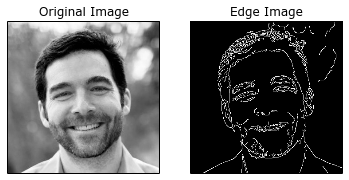

In [53]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('jeffweiner08.jpg',0)
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [52]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import collections
%matplotlib inline

#mu, sigma = 100, 15
#x = mu + sigma*np.random.randn(10000)
gender = [prof['Gender'] for prof in my_original_list]
#x= np.array(gender) 
x = collections.Counter(gender)
print x

Counter({'Male': 1472, 'Female': 1137, 'Unknown': 1})
